In [1]:
import sys
sys.path.append("..")
print(sys.path)

['/home/ws/upecj/SafeTransferLearningInChangingEnvironments/src/notebooks', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/ws/upecj/SafeTransferLearningInChangingEnvironments/venv/lib/python3.8/site-packages', '/home/ws/upecj/SafeTransferLearningInChangingEnvironments/src/custom_envs', '/home/ws/upecj/SafeTransferLearningInChangingEnvironments/venv/lib/python3.8/site-packages/IPython/extensions', '/home/ws/upecj/.ipython', '..']


In [2]:
from wrappers.preference_reward.model_wrapper import ModelWrapper
from wrappers.preference_reward.preference_reward import PreferenceReward
import gym
import custom_robotics
import wrappers
from custom_policies import custom_feature_extractor

from stable_baselines3 import SAC#, HerReplayBuffer
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback
import wandb
from wandb.integration.sb3 import WandbCallback
import numpy as np

In [3]:
config = {
    "gamma": 0.95,
    #"learning_rate": 0.0001,
    #"alpha": 0.98,
    "policy_arch": [1024, 512, 256],
    "temporal_merge": "3d_conv",
    "total_timesteps": int(5e5)
}
name = "SAC_pixel_adapt_lr_adapt_alpha"
base_folder = "../../output"
project_name = "fetch-reach-ensemble-preference"

In [4]:
run = wandb.init(
    project=project_name,
    entity="f-krone",
    name=name,
    config=config,
    #sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)
wandb.tensorboard.patch(root_logdir=f'{base_folder}/{project_name}/{name}_{run.id}/runs', pytorch=True)

wandb: Currently logged in as: f-krone (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [5]:
model_wrapper = ModelWrapper(list(map(lambda i: "../../output/fetch-reach-ensemble/SAC_ensemble_" + str(i), range(3))), obs_keys=["achieved_goal", "desired_goal", "observation"])

In [6]:
def make_env():
    env = gym.make("CustomFetchReachDense-v0")
    env = Monitor(env)  # record stats such as returns
    env = PreferenceReward(env, model_wrapper, 4, lambda steps: 1 - steps / config["total_timesteps"], tensorboard_log=f'{base_folder}/{project_name}/{name}_{run.id}/runs')
    env = wrappers.ImageAndRobot(env, 128, 128)
    env = wrappers.CropImage(env)
    env = wrappers.FrameStack(env, stack_size=4, use_3d_conv=config["temporal_merge"] == "3d_conv", add_robot=True)
    return env
def make_eval_env():
    env = gym.make("CustomFetchReachDense-v0")
    env = Monitor(env)  # record stats such as returns
    env = wrappers.ImageAndRobot(env, 128, 128)
    env = wrappers.CropImage(env)
    env = wrappers.FrameStack(env, stack_size=4, use_3d_conv=config["temporal_merge"] == "3d_conv", add_robot=True)
    return env
    
env = DummyVecEnv([make_env])
env = VecVideoRecorder(env, f"{base_folder}/{project_name}/{name}_{run.id}/videos", record_video_trigger=lambda x: x % 2000 == 0, video_length=200)
eval_env = DummyVecEnv([make_eval_env])

In [7]:
model = SAC('MultiInputPolicy', env, 
            learning_starts=int(1e4), 
            buffer_size=int(5e5),
            gamma=config["gamma"],
            learning_rate=lambda remaining: 0.0001 if remaining > 0.5 else 0.00001,
            policy_kwargs=dict(
                features_extractor_class=custom_feature_extractor.CustomFeatureExtractor,
                net_arch=config["policy_arch"]
            ),
            verbose=1, tensorboard_log=f'{base_folder}/{project_name}/{name}_{run.id}/runs')

Using cuda device


In [ ]:
model.learn(
        total_timesteps=config["total_timesteps"],
        callback=[
            WandbCallback(
                gradient_save_freq=100,
                model_save_path=f"{base_folder}/{project_name}/{name}_{run.id}/models",
                verbose=2), 
            CheckpointCallback(
                save_freq=25000, 
                save_path=f"{base_folder}/{project_name}/{name}_{run.id}/checkpoints",
                name_prefix='rl_model'),
            EvalCallback(
                eval_env, 
                best_model_save_path=f"{base_folder}/{project_name}/{name}_{run.id}/best_model",
                log_path=f"{base_folder}/{project_name}/{name}_{run.id}/best_model", 
                eval_freq=5000,
                deterministic=True,
                render=False)
        ],
    )
model.save(f"{base_folder}/{project_name}/{name}_{run.id}")

Logging to ../../output/fetch-reach-ensemble-preference/SAC_pixel_adapt_lr_adapt_alpha_2jjx2eed/runs/SAC_1
Found 3 GPUs for rendering. Using device 0.


/home/ws/upecj/SafeTransferLearningInChangingEnvironments/venv/lib/python3.8/site-packages/stable_baselines3/common/callbacks.py:337: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_video_recorder.VecVideoRecorder object at 0x7f253828d6a0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f253828d6d0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Saving video to /home/ws/upecj/SafeTransferLearningInChangingEnvironments/output/fetch-reach-ensemble-preference/SAC_pixel_adapt_lr_adapt_alpha_2jjx2eed/videos/rl-video-step-0-to-step-200.mp4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -9.89    |
|    success_rate    | 0.0      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 80       |
|    time_elapsed    | 2        |
|    total_timesteps | 200      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -10.2    |
|    success_rate    | 0.0      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 123      |
|    time_elapsed    | 3        |
|    total_timesteps | 400      |
---------------------------------
---------------------------------
| rollout/           |    

In [9]:
run.finish()

SAC_1/eval/mean_ep_length,▁
SAC_1/eval/mean_reward,▁
SAC_1/eval/success_rate,▁
SAC_1/global_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
SAC_1/rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SAC_1/rollout/ep_rew_mean,█▅▄▂▁▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂
SAC_1/rollout/success_rate,█▄▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
SAC_1/time/fps,▁▃▅▆▆▇▇███▇▇▇▇▇█████▇▇▇█▇▇▇▇▇
global_step,▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▅▁▁▁▆▁▇▁▁▁▁█▁▁▁
preference_reward/ep_action_error_mean,▂▂▅▁▄▁▂▂▄▃▁▅▂▆▃▂▁▅▄▅▄▇▄█▃
preference_reward/ep_calc_reward_mean,▃▂▅▁▂▆▆▇▆▇█▆▇▆▇▇█▇▆▆▆▆▅▅▅


In [12]:
model.save(f"{base_folder}/{name}_{run.id}")

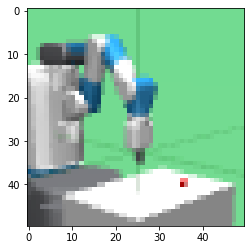

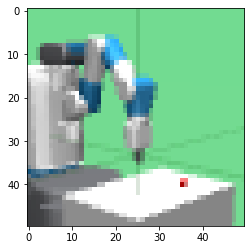

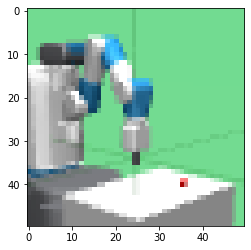

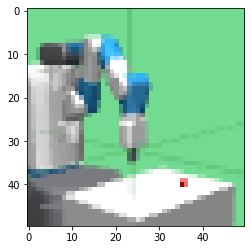

In [16]:
import matplotlib.pyplot as plt
for i, frame in enumerate(np.moveaxis(env._obs_from_buf()['frame_stack_3d'][0], 0, 1)):
    plt.figure(i)
    plt.clf()
    plt.imshow(np.moveaxis(frame, 0, -1))

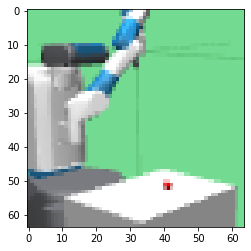

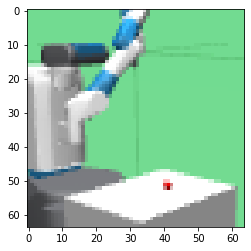

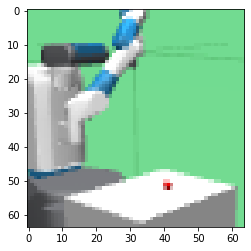

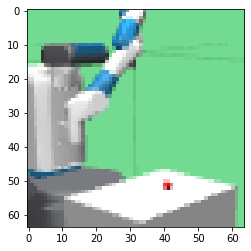

In [26]:
import matplotlib.pyplot as plt
for i, frame in enumerate(env._obs_from_buf()['frame_stack_2d'][0]):
    plt.figure(i)
    plt.clf()
    plt.imshow(frame)